In [ ]:
import os
import re
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
from Bio import SeqIO
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
from utils import similarity_matrix

## an example

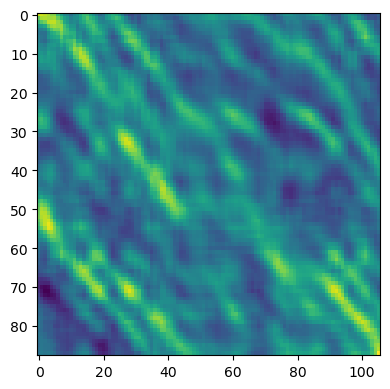

In [3]:
prostt5_embs = pickle.load(open("../embeddings/prostt5_aligned_embs.pkl", "rb"))
window_size=5

emb1 = prostt5_embs['d1slca__146']
emb2 = prostt5_embs['d1sq9a__147']
sim_matrix, (best_emb1, best_emb2, best_score) = similarity_matrix(emb1,emb2,window_size)
plt.figure(figsize=(4, 4))
plt.imshow(sim_matrix, aspect='auto', cmap='viridis')

plt.tight_layout()
plt.show()

## for aligned embs

In [4]:
protein_embeddings = pickle.load(open("../embeddings/prostt5_aligned_embs.pkl", "rb"))

df = pd.read_csv("../datasets/malisam_sequences_aligned.csv")
df["EMBEDDINGid"] = df["SCOPid"].astype(str) + '_' + df.index.astype(str) 

matrix_dict = {}
for comparison_id, group in df.groupby('PAIR'):
    ids = group['EMBEDDINGid'].drop_duplicates().tolist()
    for id1, id2 in combinations(ids, 2):
        try:
            emb1 = protein_embeddings[id1]
            emb2 = protein_embeddings[id2]
            seq_length1 = emb1.shape[0]
            seq_length2 = emb2.shape[0]

            sim_matrix, _ = similarity_matrix(emb1, emb2, 1)

            matrix_dict[comparison_id] = sim_matrix
        except:
            matrix_dict[comparison_id] = None

#with open("carp_aligned_matrix_data_5.pkl", "wb") as f:
#    pickle.dump(matrix_dict, f)
list(matrix_dict.items())[0]

('d1a05a_d1dgsa3',
 array([[ 0.68241378,  0.22974259,  0.08829296, ..., -0.04570245,
          0.14071619,  0.01923674],
        [ 0.18760573,  0.27963114,  0.23216805, ..., -0.05216505,
          0.12105911,  0.13802587],
        [ 0.17480075,  0.22423746,  0.24567643, ..., -0.03656482,
          0.06012112,  0.08228717],
        ...,
        [ 0.0580373 ,  0.03850107,  0.01506763, ...,  0.27825778,
          0.29717494,  0.0614308 ],
        [ 0.1181117 ,  0.10388878,  0.06248102, ...,  0.20623645,
          0.47488663,  0.14493535],
        [ 0.02851121,  0.08356739,  0.06148265, ...,  0.0213939 ,
          0.19243832,  0.79402324]]))

## for complete embs

In [5]:
def pdb_root(x):
    s = x.strip()
    s = re.sub(r'^pdb:', '', s, flags=re.I)       
    s = s.replace('.', '_')                       
    m = re.search(r'([0-9][A-Za-z0-9]{3})', s)
    return m.group(1).lower() if m else s.lower()

data_name = 'prostt5_complete_matrix_data'
protein_embeddings = pickle.load(open("../embeddings/prostt5_complete_embs.pkl", "rb"))

df = pd.read_csv("../datasets/malisam_complete_sequences_aligned.csv")
df["EMBEDDINGid"] = df["SCOPid"].astype(str) + '-' + df["CHAIN"].astype(str) + '_' + df.index.astype(str)

window_list = [5]
for window in window_list:
    matrix_dict = {}
    for comparison_id, group in df.groupby('PAIR'):
        entities = (
            group[['EMBEDDINGid', 'CHAIN']]
            .drop_duplicates()
            .itertuples(index=False, name=None)  
        )
        for (id1, ch1), (id2, ch2) in combinations(entities, 2):     
                   
            if pdb_root(id1) == pdb_root(id2):
                continue

            emb1 = protein_embeddings[id1]
            emb2 = protein_embeddings[id2]
            seq_length1 = emb1.shape[0]
            seq_length2 = emb2.shape[0]

            sim_matrix, _ = similarity_matrix(emb1, emb2, window)

            matrix_dict[id1+'-'+id2] = sim_matrix

    #with open(f"{data_name}_{window}.pkl", "wb") as f:
        #pickle.dump(matrix_dict, f)
list(matrix_dict.items())[0]

('d1a05a_-A_183-d1dgsa3-A_184',
 array([[0.45375484, 0.40352248, 0.4020257 , ..., 0.11558135, 0.15803406,
         0.15152014],
        [0.3185977 , 0.32354112, 0.32287673, ..., 0.09533227, 0.14043708,
         0.13424678],
        [0.24466618, 0.23906829, 0.24182638, ..., 0.0764933 , 0.13598804,
         0.13210161],
        ...,
        [0.13313081, 0.12012024, 0.12340493, ..., 0.24925498, 0.24352609,
         0.22838415],
        [0.1817456 , 0.15538328, 0.14337376, ..., 0.31576964, 0.31877761,
         0.30795702],
        [0.25506087, 0.22620749, 0.20023952, ..., 0.36365594, 0.38749861,
         0.34074649]]))